In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random

In [0]:
np.random.seed(0)
tf.set_random_seed(1234)

In [0]:
def inference(x, n_batch, maxlen, n_hidden = None , n_out = None):
  def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.01)
    return tf.Variable(initial)
  
  def bias_variable(shape):
    initial = tf.zeros(shape, dtype = tf.float32)
    return tf.Variable(initial)
  #覗き穴結合はないが計算時間が短縮できるBasicLSTMCellを採用
  cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias = 1.0)
  initial_state = cell.zero_state(n_batch, tf.float32)
  
  state = initial_state
  outputs = []
  with tf.variable_scope('LSTM'):
    for t in range(maxlen):
      if t > 0:
        tf.get_variable_scope().reuse_variables()
      (cell_output, state) = cell(x[:,t,:], state)
      outputs.append(cell_output)
      
  output = outputs[-1]
  
  V = weight_variable([n_hidden, n_out])
  c = bias_variable([n_out])
  y = tf.matmul(output, V) + c
  
  return y

In [0]:
def loss(y,t):
  mse = tf.reduce_mean(tf.square(y - t))
  return mse

In [0]:
def training(loss):
  optimizer = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999)
  train_step = optimizer.minimize(loss)
  return train_step

In [0]:
if __name__ == '__main__':
  def mask(T = 200):
    mask = np.zeros(T)
    indices = np.random.permutation(np.arange(T))[:2]
    mask[indices] = 1
    return mask
  
  def toy_problem(N = 10, T = 200):
    signals = np.random.uniform(low = 0.0, high = 1.0, size = (N,T))
    masks = np.zeros((N,T))
    for i in range(N):
      masks[i] = mask(T)
    
    data = np.zeros((N, T, 2))
    data[:,:,0] = signals[:]
    data[:,:,1] = masks[:]
    target = (signals * masks).sum(axis = 1).reshape(N, 1)
    
    return (data, target)

In [0]:
  #データ生成
  N = 10000
  T = 200
  maxlen = T
  
  X , Y = toy_problem(N = N,T = T)
  
  N_train = int(N*0.9)
  N_validation = N - N_train
  
  X_train, X_validation ,Y_train,Y_validation = train_test_split(X,Y, test_size = N_validation)

In [8]:
  #モデル設定
  n_in = len(X[0][0])
  n_hidden = 100
  n_out = len(Y[0])
  
  x = tf.placeholder(tf.float32, shape = [None, maxlen, n_in])
  t = tf.placeholder(tf.float32, shape = [None, n_out])
  n_batch = tf.placeholder(tf.int32, shape=[])
  
  y = inference(x, n_batch, maxlen = maxlen,n_hidden = n_hidden, n_out = n_out)
  loss = loss(y,t)
  train_step = training(loss)
  
  history = {
      'val_loss': []
  }

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
  #モデル学習
  epochs = 10
  batch_size = 500
  
  init = tf.global_variables_initializer()
  sess = tf.Session()
  sess.run(init)
  
  n_batches = N_train // batch_size
  X_ = X_train
  Y_ = Y_train
  
  for epoch in range(epochs):
    seed_num = random.randrange(1000)
    print('seed_num : ',seed_num)
    np.random.seed(seed_num)
    np.random.shuffle(X_)
    np.random.seed(seed_num)
    np.random.shuffle(Y_)
    
    for i in range(n_batches):
      start = i * batch_size
      end = start + batch_size
      
      sess.run(train_step, feed_dict = {
          x: X_[start:end],
          t: Y_[start:end],
          n_batch: batch_size
      })
      
    #検証データによる評価
    val_loss = loss.eval(session = sess, feed_dict = {
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    
    history['val_loss'].append(val_loss)
    print('epoch: ',epoch, 'validation loss: ',val_loss)

seed_num :  591
epoch:  0 validation loss:  0.20792453
seed_num :  234
epoch:  1 validation loss:  0.18056066
seed_num :  598
epoch:  2 validation loss:  0.17236383
seed_num :  915
epoch:  3 validation loss:  0.17294791
seed_num :  716
epoch:  4 validation loss:  0.17210068
seed_num :  953
epoch:  5 validation loss:  0.17206869
seed_num :  954
epoch:  6 validation loss:  0.17250662
seed_num :  980
epoch:  7 validation loss:  0.17209934
seed_num :  489
epoch:  8 validation loss:  0.17217295
seed_num :  102
epoch:  9 validation loss:  0.172268


<function matplotlib.pyplot.show>

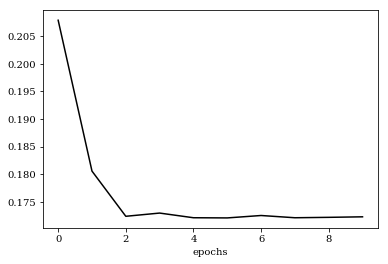

In [10]:
  #学習を可視化
  loss = history['val_loss']
  
  plt.rc('font', family = 'serif')
  fig = plt.figure()
  plt.plot(range(len(loss)), loss, label = 'loss',color = 'black')
  plt.xlabel('epochs')
  plt.show

In [16]:
  #データ生成
  T = 100
  f = toy_problem(T)
  
  length_of_sequences = 2 * T
  maxlen = 25
  data = []
  target = []
  print(f[1])
  #for i in range(0, length_of_sequences - maxlen + 1):
  #  data.append(f[i: i + maxlen])
  #  target.append(f[i + maxlen])
  #出力を用いて予測
  truncate = maxlen
  Z = X[:1]
  
  original = [f[i] for i in range(maxlen)]
  predicted = [None for i in range(maxlen)]
  
  for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = y.eval(session = sess,feed_dict = {
        x: Z[-1:],
        n_batch: 1
    })
    
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:],y_),axis = 0).reshape(1,maxlen,n_in)
    Z = np.append(Z,sequence_, axis = 0)
    predicted.append(y_.reshape(-1))
    
  #グラフで可視化
  plt.rc('font',family = 'serif')
  plt.figure()
  plt.ylim([-1.5,1.5])
  plt.plot(toy_problem(T, ampl = 0), linestyle = 'dotted', color = '#aaaaaa')
  plt.plot(original,linestyle = 'dashed', color = 'black')
  plt.plot(predicted, color = 'black')
  plt.show()

[[1.47925582]
 [0.64989136]
 [0.61638731]
 [1.38359548]
 [0.992787  ]
 [1.03963567]
 [1.11093709]
 [0.57448825]
 [0.65665598]
 [1.13890988]
 [0.84996206]
 [0.63536693]
 [1.54370531]
 [0.81807309]
 [1.30091551]
 [1.20892834]
 [1.69243146]
 [1.91044323]
 [0.88202874]
 [0.97279551]
 [0.59837608]
 [0.24015056]
 [1.03998164]
 [1.67291012]
 [1.40541291]
 [0.31405567]
 [0.87907507]
 [1.14586727]
 [1.60698546]
 [0.38292812]
 [1.47113041]
 [0.72683985]
 [1.66379749]
 [1.64499761]
 [1.38831362]
 [1.15338814]
 [1.44562879]
 [1.13275613]
 [0.7656986 ]
 [1.11325164]
 [1.37104016]
 [0.85735821]
 [1.14693051]
 [0.19443313]
 [1.31670947]
 [1.61067462]
 [0.24657063]
 [1.42098102]
 [1.56990817]
 [0.71939562]
 [0.38173914]
 [1.59975157]
 [0.64141556]
 [1.56501496]
 [0.78853565]
 [1.27733237]
 [0.92346657]
 [0.60561922]
 [1.03325379]
 [1.37001257]
 [0.89916511]
 [0.81859533]
 [1.72249025]
 [0.34188885]
 [0.32489997]
 [0.768278  ]
 [0.15087879]
 [0.23733659]
 [1.05510944]
 [0.74491633]
 [0.82834961]
 [0.80

IndexError: ignored